# Train EVI Forecast

### Import Packages

In [1]:
# System Imports
from datetime import datetime
import numpy as np
import os
import pandas as pd
import pickle

# Local Imports
from utils.config import farmbeats_config
from utils.weather_util import WeatherUtil
from utils.satellite_util import SatelliteUtil
from utils.constants import CONSTANTS
from utils.ard_util import ard_preprocess

#3rd party Imports
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)
tf.test.gpu_device_name()

''

### Get Satellite and Weatther Data

In [2]:
sat_links = pd.read_csv(CONSTANTS["sat_file_paths"])
sat_links["fileExist"] = sat_links.filePath.apply(os.path.exists)
sat_links.head()

# TODO: Check fileExist is True for all rows 

,fileLink,name,resolution,id,sceneDateTime,boundaryId,cloudCoverPercentage,darkPixelPercentage,boundary_count,filePath,fileExist
0,https://agadhibjs-one.farmbeats-dogfood.azure....,NDVI,10.0,686ef1c2-95ce-97cc-bf75-a25dbe3bd291,2021-04-22T00:00:00.000Z,boundary057,0.0,0.0,65,C:\farmbeats\Microsoft\Sentinel_2_L2A\annam_fa...,True
1,https://agadhibjs-one.farmbeats-dogfood.azure....,NDVI,10.0,4d655f49-4071-0d76-42f9-65295fa7184a,2021-04-10T00:00:00.000Z,boundary057,0.0,0.0,65,C:\farmbeats\Microsoft\Sentinel_2_L2A\annam_fa...,True
2,https://agadhibjs-one.farmbeats-dogfood.azure....,NDVI,10.0,87d65973-fba8-ef49-4504-887e9b5da99c,2021-04-02T00:00:00.000Z,boundary057,0.0,0.0,65,C:\farmbeats\Microsoft\Sentinel_2_L2A\annam_fa...,True
3,https://agadhibjs-one.farmbeats-dogfood.azure....,NDVI,10.0,5ef5ea54-6a51-f430-7226-9417dac58d1c,2021-03-31T00:00:00.000Z,boundary057,0.0,0.0,65,C:\farmbeats\Microsoft\Sentinel_2_L2A\annam_fa...,True
4,https://agadhibjs-one.farmbeats-dogfood.azure....,NDVI,10.0,74a7e2ff-919c-b73d-1d50-b6bb1de7bbdc,2021-03-18T00:00:00.000Z,boundary057,0.0,0.0,65,C:\farmbeats\Microsoft\Sentinel_2_L2A\annam_fa...,True


In [15]:
w_parms = [
    "airTempMin-F",
    "dewPointMin-F",
    "windSpeed-mph",
    "precipitation-in",
    "relativeHumidity-%",
    "temperature-F",
    "windSpeed2mAvg-mph",
    "snowAccPeriod-in",
    "liquidAccPeriod-in",
    "windSpeed2mMin-mph",
    "sunshineDuration-hours",
    "relativeHumidityMax-%",
    "relativeHumidityMin-%",
    "shortWaveRadiationAvg-W/m^2",
    "dewPointMax-F",
    "petPeriod-in",
    "windSpeedMin-mph",
    "iceAccPeriod-in",
    "airTempMax-F",
    "windSpeed2mMax-mph",
    "dewPoint-F",
    "cloudCover-%",
    "longWaveRadiationAvg-W/m^2",
    "windSpeedMax-mph",
]

In [16]:
trainval = (
    sat_links.drop_duplicates(["boundaryId", "fileExist"])
    .groupby(["boundaryId"])["fileExist"]
    .agg({"count"})
    .reset_index()
    .query("count == 1")
    .drop(["count"], axis=1)
)


trainval["w_exists"] = (CONSTANTS["weather_data_fldr"] + trainval["boundaryId"] + "_historical.csv").apply(
    os.path.exists
)

trainval = trainval.query("w_exists")
np.random.seed(10)
trainval["trainval"] = np.where(
    np.random.uniform(0, 1, trainval.shape[0]) < 0.8, "Train", "Val"
)

In [17]:
# TODO: Tobe removed once no_boundaries are more than 1
trainval = pd.concat([trainval]*2, ignore_index=True)
trainval.loc[1,'trainval'] = 'Val'
trainval

,boundaryId,w_exists,trainval
0,boundary057,True,Train
1,boundary057,True,Val


In [6]:
# get mean and standard deviation of training data weather parameters for normalization
w_stats = pd.concat(
    [
        pd.read_csv(CONSTANTS["weather_data_fldr"] + x + "_historical.csv")
        for x in trainval.query('trainval == "Train"').boundaryId.values
    ],
    axis=0,
)[w_parms].agg({"mean", "std"})
w_mn = w_stats.filter(like="mean", axis=0)[w_parms].values
w_sd = w_stats.filter(like="std", axis=0)[w_parms].values

In [7]:
def get_ARD(boundaryId):
    # function for preparing Analysis Ready Dataset
    # intended for use in _2_build_model.py
    
    sat_links1 = sat_links.query(
        'boundaryId == @boundaryId'
    )
     
    # in reading w_df, if error occurs with farm_code, change it to field_id
    w_df = pd.read_csv(CONSTANTS["weather_data_fldr"] + boundaryId + "_historical.csv")
    
    da_pc = ard_preprocess(
        sat_links1=sat_links1,
        w_df=w_df,
        sat_res_x=CONSTANTS["sat_res_x_model"],
        var_name=CONSTANTS["var_name"],
        interp_date_start=CONSTANTS["interp_date_start"],
        interp_date_end=CONSTANTS["interp_date_end"],
        w_parms=w_parms,
        input_days=CONSTANTS["input_days"],
        output_days=CONSTANTS["output_days"],
        ref_tm=CONSTANTS["ref_tm_model"],
        w_mn=w_mn,
        w_sd=w_sd,
    )
    return da_pc.query(
        "nan_input_evi and nan_input_w and nan_output_evi and nan_output_w and input_evi_le1 and output_evi_le1"
    )

### Create Analysis Ready Dataset

In [8]:
# Get analysis ready dataset
from concurrent.futures import ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=100) as executor:
    ards_fetch = [executor.submit(get_ARD, x) for x in trainval.boundaryId.values]

C:\azure-farmbeats-samples\evi_forecast\utils\ard_util.py:148: RuntimeWarning: All-NaN slice encountered
  np.nanmax(np.abs(np.array(da3.input_evi.to_list())), axis=(1, 2)) <= 1
C:\azure-farmbeats-samples\evi_forecast\utils\ard_util.py:151: RuntimeWarning: All-NaN slice encountered
  np.nanmax(np.abs(np.array(da3.output_evi.to_list())), axis=(1, 2)) <= 1


In [9]:
ards_fetch[0].result()

,lat_,long_,grp1_,input_evi,input_weather,forecast_weather,output_evi,input_evi_le1,output_evi_le1,nan_input_evi,nan_input_w,nan_output_evi,nan_output_w
0,-97.065187,46.659193,0.0,"[[0.14545853660344957], [0.1452836268486312], ...","[[0.8807729150205813, 0.033227162972511, 0.644...","[[0.5515432377105828, 0.08091791453305612, 1.3...","[[0.14953226908455836], [0.1502470210119132], ...",True,True,True,True,True,True
1,-97.065187,46.659193,1.0,"[[0.15394681022594542], [0.15433201997788878],...","[[0.8807729150205813, 0.5578254301385074, 1.11...","[[1.0218713481534378, 1.3685682066677745, -1.2...","[[0.15812118018641771], [0.15804493191910887],...",True,True,True,True,True,True
2,-97.065187,46.659193,2.0,"[[0.15786298955955427], [0.15789449227358957],...","[[1.1159369702420088, 1.3208774551072293, -1.2...","[[1.3511010254634361, 1.7024034675915904, -0.3...","[[0.1724136557905433], [0.17279570766301516], ...",True,True,True,True,True,True
3,-97.065187,46.659193,3.0,"[[0.1771830214145044], [0.17764796616187736], ...","[[0.8807729150205813, 1.177805200425594, -1.48...","[[0.5045104266662973, 0.6532069332595977, 0.64...","[[0.1640148825464738], [0.16214338547164542], ...",True,True,True,True,True,True
4,-97.065187,46.659193,4.0,"[[0.14761277385493554], [0.1460269832851682], ...","[[-0.5772442273522691, -0.49137110419348534, 0...","[[-0.34208017213084163, -0.10984509170912438, ...","[[0.14344046805539826], [0.14546853682630437],...",True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,-97.057108,46.670025,3.0,"[[0.76316974987535], [0.7513498363269698], [0....","[[0.8807729150205813, 1.177805200425594, -1.48...","[[0.5045104266662973, 0.6532069332595977, 0.64...","[[0.324271030679295], [0.3110797403073121], [0...",True,True,True,True,True,True
1246,-97.057108,46.670025,4.0,"[[0.20242497073094567], [0.1921287470317206], ...","[[-0.5772442273522691, -0.49137110419348534, 0...","[[-0.34208017213084163, -0.10984509170912438, ...","[[0.15474000614116906], [0.15705125161866823],...",True,True,True,True,True,True
1247,-97.057108,46.670025,5.0,"[[0.18808466868215015], [0.19170052524160658],...","[[-1.0946051488394095, -0.8728971166778463, -0...","[[-0.67130984944084, -0.44368035263294026, -1....","[[0.1352856450244162], [0.1299944221301206], [...",True,True,True,True,True,True
1248,-97.057108,46.670025,6.0,"[[0.08964094182648821], [0.08589557858581923],...","[[-1.0005395267508386, -0.8728971166778463, -0...","[[-1.800097314503692, -1.8267121478887487, 0.1...","[[0.01397652528151022], [0.013101723940852593]...",True,True,True,True,True,True


In [10]:
da_fin = pd.concat(
    [
        ards_fetch[x]
        .result()
        .assign(
            farm_code=trainval.boundaryId.values[x], trainval=trainval.trainval.values[x]
        )
        for x in range(len(trainval.boundaryId.values))
        if ards_fetch[x].exception() == None
    ],
    axis=0,
)

### Model Data Preparation

In [11]:
da_train = da_fin.query('trainval == "Train"')
da_val = da_fin.query('trainval == "Val"')

# Prepare train and validation tensors
# converting list variables in ARD DataFrame to numpy array (tensors)
X_train = [
    np.array(da_train.input_evi.to_list()),
    np.array(da_train.input_weather.to_list()),
    np.array(da_train.forecast_weather.to_list()),
]
Y_train = np.array(da_train.output_evi.to_list())
X_val = [
    np.array(da_val.input_evi.to_list()),
    np.array(da_val.input_weather.to_list()),
    np.array(da_val.forecast_weather.to_list()),
]
Y_val = np.array(da_val.output_evi.to_list())

# Save Analysis Ready Dataset (ARD)
os.makedirs(os.path.dirname(CONSTANTS["ardpkl"]), exist_ok=True)
with open(CONSTANTS["ardpkl"], "wb") as f:
    pickle.dump(da_fin, f)

# Save weather parameters normalization stats
os.makedirs(os.path.dirname(CONSTANTS["w_pkl"]), exist_ok=True)
with open(CONSTANTS["w_pkl"], "wb+") as f:
    pickle.dump([w_parms, w_mn, w_sd], f)

### Model Architecture

In [12]:
def get_model(input_weather, x, y, z):
    """
    Model architecture
    """
    # intended for use in _2_build_model.py
    # Define the tensors for the three input images
    evi_input = keras.Input((CONSTANTS["input_days"], 1), name="evi_input")
    weather_input = keras.Input(
        (CONSTANTS["input_days"], input_weather), name="weather_input"
    )
    forecast_input = keras.Input(
        (CONSTANTS["output_days"], input_weather), name="forecast_input"
    )

    dense_1 = keras.layers.LSTM(
        x, activation="relu", name="DeNse_1", dropout=0.1, recurrent_dropout=0.1
    )(evi_input)
    dense_2 = keras.layers.LSTM(
        y, activation="relu", name="DeNse_2", dropout=0.1, recurrent_dropout=0.1
    )(weather_input)
    dense_3 = keras.layers.LSTM(
        z,
        activation="relu",
        name="lstm_1",
        return_sequences=True,
        dropout=0.1,
        recurrent_dropout=0.1,
    )(forecast_input)

    dense_12 = keras.layers.concatenate(axis=-1, inputs=[dense_1, dense_2])
    dense_12_1 = keras.layers.RepeatVector(10)(dense_12)
    dense_123 = keras.layers.concatenate(axis=-1, inputs=[dense_12_1, dense_3])
    prediction = keras.layers.LSTM(
        1, activation="relu", name="lstm_2", return_sequences=True
    )(dense_123)
    # Connect the inputs with the outputs
    finnet = keras.Model(
        inputs=[evi_input, weather_input, forecast_input], outputs=prediction
    )
    # return the model
    return finnet

### Model Training

In [13]:
model = get_model(len(w_parms), 100, 100, 100)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer, metrics=["mse"])
# Model run
history1 = model.fit(
    X_train,
    Y_train,
    epochs=20,
    verbose=0,
    validation_data=(X_val, Y_val),
    callbacks=[],
    batch_size=1000,
)
val_pred = model.predict(X_val)
# Save model to h5 format
tf.keras.models.save_model(
    model, filepath= CONSTANTS["modelh5"], save_format="h5", overwrite=True
)

### Visualization

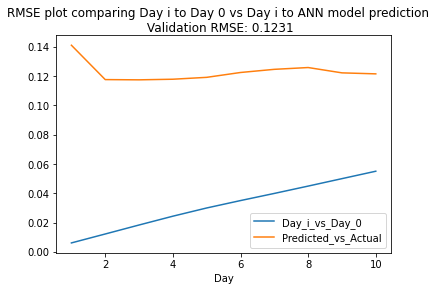

In [14]:
# visualize model error as function of forecast days
err_pred = Y_val[:, :, 0] - val_pred[:, :, 0]
err_base = -Y_val[:, :, 0] + X_val[0][:, -1, 0][:, np.newaxis]
df_err_mn = pd.DataFrame(
    {
        "Day_i_vs_Day_0": np.sqrt(np.mean(err_base ** 2, axis=0)),
        "Predicted_vs_Actual": np.sqrt(np.mean(err_pred ** 2, axis=0)),
        "Day": 1 + np.arange(CONSTANTS["output_days"]),
    }
).set_index(["Day"])
df_err_mn.plot()
plt.suptitle(
    "RMSE plot comparing Day i to Day 0 vs Day i to ANN model prediction\n Validation RMSE: "
    + str(np.round(np.sqrt(history1.history["val_mse"][-1]), 4))
)
plt.savefig(CONSTANTS["model_result_png"])